In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [3]:
import numpy as np
import xarray as xr

from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

### Configuration parameters

In [4]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

### Load moment calculations

In [5]:
ds = xr.open_dataset("../../data/BBTRE-tracer/tracer_moments.nc")
ds_t = xr.open_dataset("../../data/BBTRE-tracer/time-approx_tracer_moments.nc")

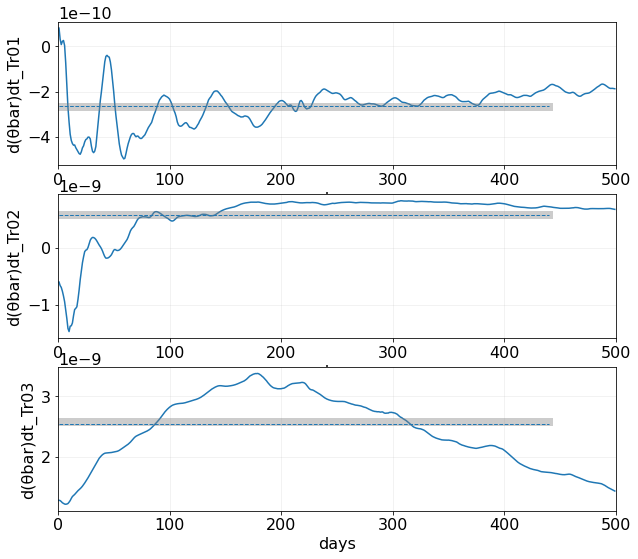

In [6]:
plt.figure(figsize=(10,9))
for tr in [1, 2, 3]:
    plt.subplot(3,1,tr)
    (0.5*ds[f"d(θbar)dt_Tr0{tr}"]).plot(x='days')
    plt.plot([1, 440], np.array([1., 1.])*0.5*ds_t[f"d(θbar)dt_LHS-approx_Tr0{tr}"].values, color="grey", ls="-", lw=8, alpha=0.4)
    plt.plot([1, 440], np.array([1., 1.])*(0.5*ds[f"d(θbar)dt_Tr0{tr}"]).isel(time=slice(0, 440)).mean('time').values, color="C0", ls="--", lw=1)
    plt.xlim(0, 500)
    plt.grid(True, alpha=0.2)

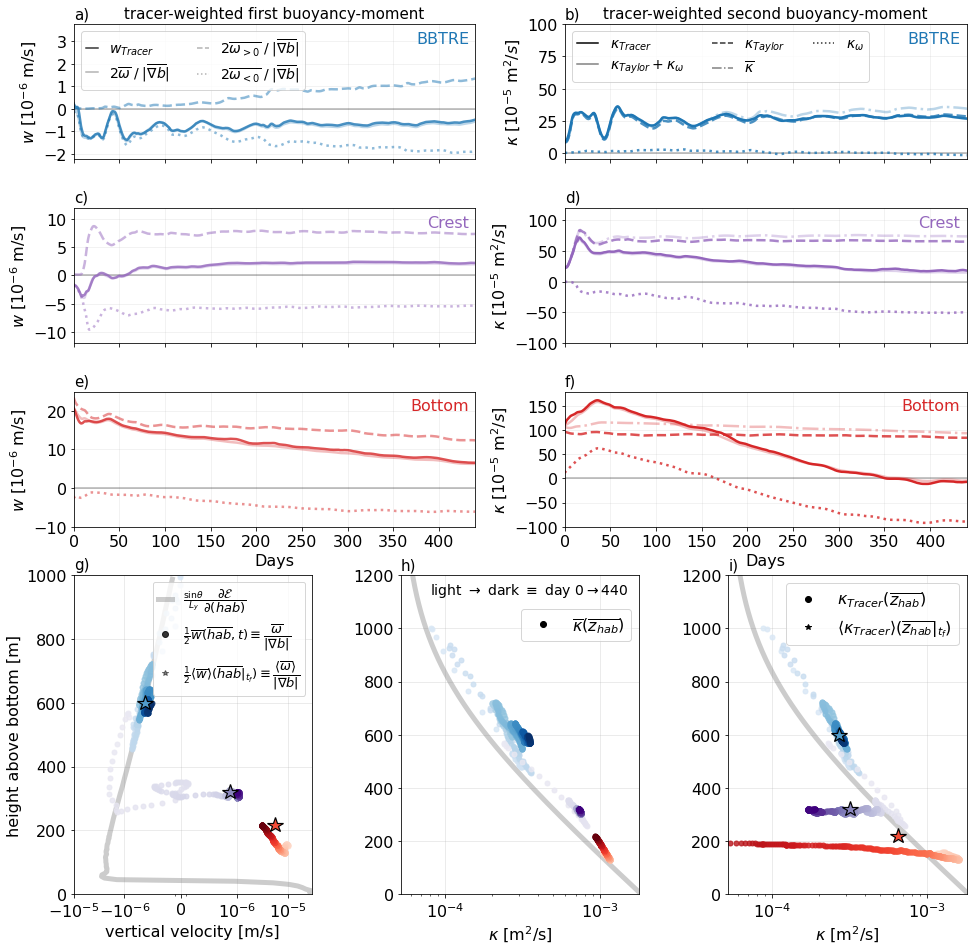

In [37]:
fig = plt.figure(figsize=(16,16))#, constrained_layout=True)
gs = fig.add_gridspec(5, 6, hspace=0.36, wspace=1.2)

tr_names = {1: "BBTRE", 2: "Crest", 3: "Bottom"}
tr_cols = {1: "C0", 2: "C4", 3: "C3"}

axes = {
    "w": [fig.add_subplot(gs[0, :3]), fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[2, :3])],
    "κ": [fig.add_subplot(gs[0, 3:]), fig.add_subplot(gs[1, 3:]), fig.add_subplot(gs[2, 3:])],
    "hab": [fig.add_subplot(gs[3:, 0:2]), fig.add_subplot(gs[3:, 2:4]), fig.add_subplot(gs[3:, 4:6])]
}

### w
ax = axes["w"][0]
ax.plot([],[],"k-", label=r"$w_{Tracer}$", alpha=0.8)
ax.plot([],[],"k-", alpha=0.3, label=r"$2\overline{\omega}\; / \;\left| \overline{\nabla b} \right|$")
ax.plot([],[],"k--", alpha=0.3, label=r"$2\overline{\omega_{>0}}\; / \;\left| \overline{\nabla b} \right|$")
ax.plot([],[],"k:", alpha=0.3, label=r"$2\overline{\omega_{<0}}\; / \;\left| \overline{\nabla b} \right|$")
ax.legend(loc="upper left", ncol=2, labelspacing=0.3, handlelength=0.8, fontsize=14)

for tr in [1,2,3]:
    ax = axes["w"][tr-1]
    ax.grid(True, alpha=0.2)
    ax.axhline(0., color="k", alpha=0.3, lw=1.5)
    ax.plot(ds[f"2ω_Tr0{tr}"]/ds[f"Gradθ**2bar_Tr0{tr}"]**0.5*1e6, lw=2.5, c=tr_cols[tr], ls="-", alpha=0.3)
    ax.plot(2*ds[f"ωbar_BBL_Tr0{tr}"]/ds[f"Gradθ**2bar_Tr0{tr}"]**0.5*1e6, lw=2.5, c=tr_cols[tr], ls="--", alpha=0.5)
    ax.plot(2*ds[f"ωbar_SML_Tr0{tr}"]/ds[f"Gradθ**2bar_Tr0{tr}"]**0.5*1e6, lw=2.5, c=tr_cols[tr], ls=":", alpha=0.5)
    ax.plot(ds[f"d(θbar)dt_Tr0{tr}"]/ds[f"Gradθ**2bar_Tr0{tr}"]**0.5*1e6, lw=2.5, c=tr_cols[tr], ls="-", alpha=0.8)
    ax.set_xlim(0, 440)
    ax.set_ylabel(r"$w$ [10$^{-6}$ m/s]")
    ax.annotate(tr_names[tr], xy=(0.985, 0.86), xycoords="axes fraction", color=tr_cols[tr], horizontalalignment="right")
    if tr in [1,2]:
        ax.set_xticks(np.arange(0, 450, 50))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(0, 450, 50))
ax.set_xlabel("Days")

### k
ax = axes["κ"][0]
ax.plot([],[],"k-", label=r"$\kappa_{Tracer}$")
ax.plot([],[],"k-", alpha=0.5, label=r"$κ_{Taylor} + κ_{ω}$")
ax.plot([],[],"k-", alpha=0.5, label="")
ax.plot([],[],"k--", alpha=0.8, label=r"$κ_{Taylor}$")
ax.plot([],[],"k-.", alpha=0.5, label=r"$\overline{κ}$")
ax.plot([],[],"k:", alpha=0.8, label=r"$κ_{ω}$")
ax.legend(loc="upper left", ncol=3, labelspacing=0.4, handlelength=1.5, fontsize=14)

for tr in [1,2,3]:
    ax = axes["κ"][tr-1]
    ax.grid(True, alpha=0.2)
    ax.axhline(0., color="k", alpha=0.3, lw=1.5)
    ax.plot(1e5*(ds[f"κTaylor_Tr0{tr}"]+ds[f"κOmega_Tr0{tr}"]), lw=2.5, c=tr_cols[tr], ls="-", alpha=0.3)
    ax.plot(1e5*ds[f"κTracer_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls="-")
    ax.plot(1e5*ds[f"κTaylor_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls="--", alpha=0.8)
    ax.plot(1e5*ds[f"κbar_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls="-.", alpha=0.3)
    ax.plot(1e5*ds[f"κOmega_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls=":", alpha=0.8)
    ax.set_xlim(0, 440)
    ax.set_ylim(2e5*-10*k0, 1e5*1.1*k1)
    ax.set_ylabel(r"$κ$ [10$^{-5}$ m$^{2}/s$]")
    ax.annotate(tr_names[tr], xy=(0.985, 0.86), xycoords="axes fraction", color=tr_cols[tr], horizontalalignment="right")
    if tr in [1,2]:
        ax.set_xticks(np.arange(0, 450, 50))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(0, 450, 50))
ax.set_xlabel("Days")

### hab
nt = 440
zplot = np.arange(0, 1500., 1.)

cmaps = [
    None,
    matplotlib.cm.get_cmap("Blues"),
    matplotlib.cm.get_cmap("Purples"),
    matplotlib.cm.get_cmap("Reds")
]

Ly = 600.*100.
wmt = xr.open_dataset("../../data/BBTRE-physics/wmt_total.nc")

#
ax = axes["hab"][0]
ax.grid(True, alpha=0.3)
w_hab = (wmt["E_hab"]/wmt["dZ_habC_bin"]).mean("time")*(np.sin(θ)/Ly)
w_hab.plot(ax=ax, y="Z_habC_bin", lw=5., color="grey", alpha=0.4, label=r"$\frac{\sin{\theta}}{L_{y}} \dfrac{\partial \mathcal{E}}{\partial (hab)}$")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.plot(
            (ds[f'2ω_Tr0{tr}'][t]/2)/(ds[f'Gradθ**2bar_Tr0{tr}'][t]**0.5),
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8
        )
for tr in [1,2,3]:
    ax.plot(
        ((ds[f'2ω_Tr0{tr}']/2)/ds[f'Gradθ**2bar_Tr0{tr}']**0.5).isel(time=slice(0, nt)).mean(),
        ds[f'HABbar_Tr0{tr}'][nt],
        color=cmaps[tr](0.15+0.85*ds['days'][nt//2].values/nt),
        marker="*",
        markersize=16,
        markeredgecolor="k",
        markeredgewidth=1.2,
        alpha=1.
    )
ax.plot([], [], "ko", alpha=0.8, label=r"$\frac{1}{2}\overline{w}(\overline{hab}, t) \equiv \dfrac{\overline{\omega}}{|\nabla b|}$")
ax.plot([], [], "k*", alpha=0.5, label=r"$\frac{1}{2}\langle \overline{w} \rangle (\overline{hab}|_{t_{f}}) \equiv \dfrac{\langle \overline{\omega} \rangle}{|\nabla b|}$")
ax.set_xscale('symlog', linthreshx=1e-7, linscalex=0.1)
ax.set_xticks([-1e-5, -1e-6, 0, 1e-6, 1e-5])
ax.set_ylim(0, 1000)
ax.set_xlim(-1e-5, 3e-5)
ax.set_title("")
ax.legend(handlelength=1.1, loc="upper right", fontsize=13)
ax.set_ylabel("height above bottom [m]")
ax.set_xlabel("vertical velocity [m/s]")

#
ax = axes["hab"][1]
ax.grid(True, alpha=0.3)
ax.semilogx(k0+k1*np.exp(-zplot/h), zplot, lw=5, c="grey", alpha=0.4)
ax.set_title("")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.semilogx(
            ds[f'κbar_Tr0{tr}'][t],
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8,
        )
ax.plot([], [], "ko", label=r"$\overline{κ}(\overline{z_{hab}})$")
ax.set_xlim(k0, k1)
ax.set_ylim(0, 1200)
ax.set_xlabel(r"$κ$ [m$^{2}$/s]")
ax.annotate(r"light $\rightarrow$ dark $\equiv$ day $0 \rightarrow 440$", xy=(0.12, 0.94), xycoords="axes fraction", fontsize=14)
ax.legend(loc="upper right", bbox_to_anchor=(0., 0., 1.0, 0.92))

ax = axes["hab"][2]
ax.grid(True, alpha=0.3)
ax.semilogx(k0+k1*np.exp(-zplot/h), zplot, lw=5, c="grey", alpha=0.4)
ax.set_title("")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.semilogx(
            ds[f'κTracer_Tr0{tr}'][t],
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8
        )
for tr in [1,2,3]:
    ax.plot(
        ds[f'κTracer_Tr0{tr}'].isel(time=slice(0, nt)).mean(),
        ds[f'HABbar_Tr0{tr}'][nt],
        color=cmaps[tr](0.15+0.85*ds['days'][nt//2].values/nt),
        marker="*",
        markersize=16,
        markeredgecolor="k",
        markeredgewidth=1.2,
        alpha=1.
    )
ax.plot([], [], "ko", label=r"$κ_{Tracer}(\overline{z_{hab}})$")
ax.plot([], [], "k*", label=r"$\langle κ_{Tracer} \rangle (\overline{z_{hab}}|_{t_{f}})$")
ax.set_xlim(k0, k1)
ax.set_ylim(0, 1200)
ax.set_xlabel(r"$κ$ [m$^{2}$/s]")
ax.legend(loc="upper right")

#plt.tight_layout()

axes["w"][0].set_yticks(np.arange(-2, 4, 1))
axes["w"][0].set_ylim(-2.25, 3.75)
axes["w"][1].set_yticks(np.arange(-10, 20, 5))
axes["w"][1].set_ylim(-12, 12)
axes["w"][2].set_yticks(np.arange(-10, 30, 10))
axes["w"][2].set_ylim(-10, 25)

axes["κ"][0].set_yticks(np.arange(0, 125, 25))
axes["κ"][0].set_ylim(-5, 100)
axes["κ"][1].set_yticks(np.arange(-100, 150, 50))
axes["κ"][1].set_ylim(-100, 120)
axes["κ"][2].set_yticks(np.arange(-100, 200, 50))
axes["κ"][2].set_ylim(-100, 180)

axes["w"][0].set_title("tracer-weighted first buoyancy-moment", fontsize=15)
axes["κ"][0].set_title("tracer-weighted second buoyancy-moment", fontsize=15)

axes["w"][0].set_title("a)", loc="left", fontsize=15)
axes["κ"][0].set_title("b)", loc="left", fontsize=15)
axes["w"][1].set_title("c)", loc="left", fontsize=15)
axes["κ"][1].set_title("d)", loc="left", fontsize=15)
axes["w"][2].set_title("e)", loc="left", fontsize=15)
axes["κ"][2].set_title("f)", loc="left", fontsize=15)
axes["hab"][0].set_title("g)", loc="left", fontsize=15)
axes["hab"][1].set_title("h)", loc="left", fontsize=15)
axes["hab"][2].set_title("i)", loc="left", fontsize=15)

plt.savefig("../../figures/BBTRE-tracer/tracer_moments.png", bbox_inches="tight", dpi=200.)

### Decomposing the buoyancy stretching term

In [8]:
dz = 5.
hlevs = np.append( np.arange(-dz/2, 200.-dz, dz), np.arange(200., 1500.+dz*5, dz*5) )

dhab = np.diff(hlevs)
ds["dZ_habC_bin"] = xr.DataArray(dhab, coords={"Z_habC_bin": ds["Z_habC_bin"].values}, dims="Z_habC_bin")

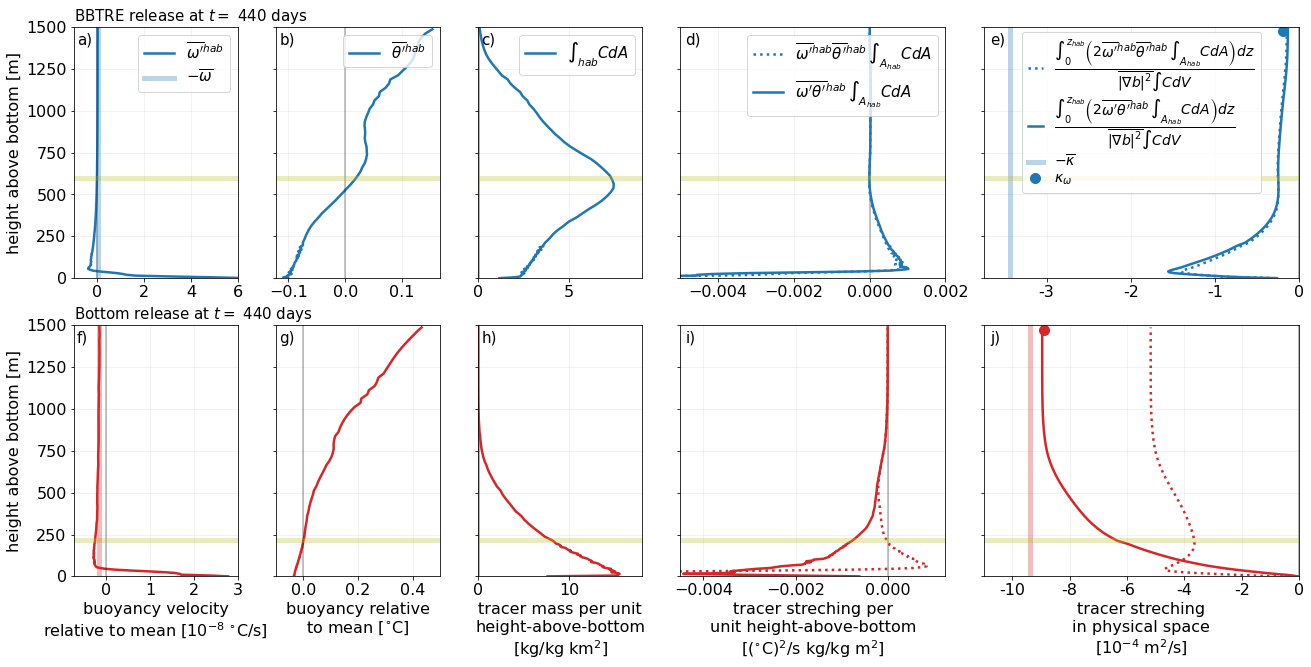

In [11]:
t = 440

scale = 1.1
fig = plt.figure(figsize=(17*scale,8.5*scale))
gs = fig.add_gridspec(2, 25)

colors = ["C0", "C3"]

axes = {
    "ω": [fig.add_subplot(gs[0, 0:4]), fig.add_subplot(gs[1, 0:4])],
    "b": [fig.add_subplot(gs[0, 4:8]), fig.add_subplot(gs[1, 4:8])],
    "C": [fig.add_subplot(gs[0, 8:12]), fig.add_subplot(gs[1, 8:12])],
    "ωbC": [fig.add_subplot(gs[0, 12:18]), fig.add_subplot(gs[1, 12:18])],
    "intωbC": [fig.add_subplot(gs[0, 18:25]), fig.add_subplot(gs[1, 18:25])],
}


for (i, tr) in enumerate([1, 3]):
    ax = axes["ω"][i]
    ds[f"ωp_Tr0{tr}_hab"].isel(time=t).plot(ax=ax, y="Z_habC_bin", label=r"$\overline{\omega^{\prime}}^{hab}$", color=colors[i], lw=2.5)
    ax.axvline(0., color="k", alpha=0.3, lw=1.5)
    ax.grid(True, alpha=0.2)
    ax.set_ylabel("height above bottom [m]")
    ax.set_xlabel("")
    if i==1: ax.set_xlabel("buoyancy velocity\n"+r"relative to mean [$10^{-8}\; ^{\circ}$C/s]")
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.int64(xticks*1e8))
    ax.set_ylim([0, 1500])
    ax.set_title("")
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    ax.axvline(-ds[f"ωbar_Tr0{tr}"].isel(time=t), color=colors[i], lw=5, ls="-", alpha=0.3, label=r"$-\overline{\omega}$")
    if i==0: ax.legend(loc="upper right", fontsize=15)
    
    ax = axes["b"][i]
    ds[f"θp_Tr0{tr}_hab"].isel(time=t).plot(ax=ax, y="Z_habC_bin", label=r"$\overline{\theta^{\prime}}^{hab}$", color=colors[i], lw=2.5)
    ax.axvline(0., color="k", alpha=0.3, lw=1.5)
    ax.grid(True, alpha=0.2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("")
    ax.set_ylim([0, 1500])
    ax.set_title("")
    ax.set_xlabel("")
    if i==1: ax.set_xlabel("buoyancy relative\n"+r"to mean [$^{\circ}$C]")
    if i==0: ax.legend(loc="upper right", fontsize=15)
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    
    ax = axes["C"][i]
    ax.axvline(0., color="k", alpha=0.3, lw=3.0)
    (ds[f"M_Tr0{tr}_hab"]/ds["dZ_habC_bin"]).isel(time=t).plot(ax=ax, y="Z_habC_bin", label=r"$\int_{hab} C dA$", color=colors[i], lw=2.5)
    ax.grid(True, alpha=0.2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.int64(xticks*1e-6))
    ax.set_xlabel("")
    if i==1: ax.set_xlabel("tracer mass per unit\nheight-above-bottom\n"+r"[kg/kg km$^{2}$]")
    ax.set_ylabel("")
    ax.set_ylim([0, 1500])
    ax.set_title("")
    if i==0: ax.legend(loc="upper right", fontsize=15)
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    
    ax = axes["ωbC"][i]
    ax.axvline(0., color="k", alpha=0.3, lw=1.5)
    ((ds[f"θp_Tr0{tr}_hab"]*ds[f"ωp_Tr0{tr}_hab"])*ds[f"M_Tr0{tr}_hab"]/ds["dZ_habC_bin"]).isel(time=t).plot(ax = ax,
        y="Z_habC_bin", label=r"$\overline{\omega^{\prime}}^{hab} \overline{\theta^{\prime}}^{hab}\, \int_{A_{hab}} C dA$", color=colors[i], linestyle=":", lw=2.5
    )
    (ds[f"ωpθp_bar_Tr0{tr}_hab"]*ds[f"M_Tr0{tr}_hab"]/ds["dZ_habC_bin"]).isel(time=t).plot(ax = ax,
        y="Z_habC_bin", label=r"$\overline{\omega^{\prime} \theta^{\prime}}^{hab}\, \int_{A_{hab}} C dA$", color=colors[i], lw=2.5
    )
    ax.grid(True, alpha=0.2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("")
    ax.set_xlim([-1.5e-3,1.5e-3])
    ax.set_ylim([0, 1500])
    if i==0: ax.legend(loc="upper right", fontsize=15)
    ax.set_title("")
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    if i==1: ax.set_xlabel("tracer streching per\nunit height-above-bottom\n"+r"[($^{\circ}$C)$^{2}$/s kg/kg m$^{2}$]")
    
    ax = axes["intωbC"][i]
    ax.axvline(0., color="k", alpha=0.3, lw=3.0)
    ((2*(ds[f"θp_Tr0{tr}_hab"]*ds[f"ωp_Tr0{tr}_hab"])*ds[f"M_Tr0{tr}_hab"]).cumsum("Z_habC_bin")/(ds[f'Gradθ**2bar_Tr0{tr}']*ds[f"M_Tr0{tr}"])).isel(time=t).plot(ax = ax,
        y="Z_habC_bin", label=r"$\dfrac{\int^{z_{hab}}_{0} \left( 2 \overline{\omega^{\prime}}^{hab} \overline{\theta^{\prime}}^{hab}\, \int_{A_{hab}} C dA \right) dz}{\overline{|\nabla b|^{2}} \int C dV}$",
        color=colors[i], linestyle=":", lw=2.5
    )
    ((2*ds[f"ωpθp_bar_Tr0{tr}_hab"]*ds[f"M_Tr0{tr}_hab"]).cumsum("Z_habC_bin")/(ds[f'Gradθ**2bar_Tr0{tr}']*ds[f"M_Tr0{tr}"])).isel(time=t).plot(ax=ax,
        y="Z_habC_bin", label=r"$\dfrac{\int^{z_{hab}}_{0} \left( 2 \overline{\omega^{\prime} \theta^{\prime}}^{hab}\, \int_{A_{hab}} C dA \right) dz}{\overline{|\nabla b|^{2}} \int C dV}$", color=colors[i], lw=2.5
    )
    ax.axvline(
        (-ds[f"κbar_Tr0{tr}"]).isel(time=t),
        color=colors[i], lw=5, ls="-", alpha=0.3, label=r"$-\overline{\kappa}$",
    )
    ax.plot(
        (ds[f"κOmega_Tr0{tr}"]).isel(time=t).values, [1475], "o",
        color=colors[i], markersize=10, label=r"$\kappa_{\omega}$",
    )
    ax.grid(True, alpha=0.2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("")
    ax.set_ylim([0, 1500])
    if i==0: ax.legend(loc="upper right", labelspacing=0.15, handlelength=1.1, fontsize=14, bbox_to_anchor=(0.3, 0.51, 0.6, 0.5))
    ax.set_title("")
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    if i==1: ax.set_xlabel("tracer streching\nin physical space\n"+r"[10$^{-4}$ m$^{2}$/s]")
    
plt.tight_layout(w_pad=0.175, h_pad=1.2)

axes["ω"][0].set_title(r"BBTRE release at $t =$ 440 days", loc="left", fontsize=15)
axes["ω"][0].annotate(s="a)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["b"][0].annotate(s="b)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["C"][0].annotate(s="c)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["ωbC"][0].annotate(s="d)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["intωbC"][0].annotate(s="e)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["ω"][1].set_title(r"Bottom release at $t =$ 440 days", loc="left", fontsize=15)
axes["ω"][1].annotate(s="f)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["b"][1].annotate(s="g)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["C"][1].annotate(s="h)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["ωbC"][1].annotate(s="i)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["intωbC"][1].annotate(s="j)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)

axes["ω"][0].set_xlim(-1e-8, 6e-8)
axes["ω"][0].set_xticks(np.arange(0, 7, 2)*1e-8)
axes["ω"][0].set_xticklabels(np.int64(np.arange(0, 7, 2)))
axes["C"][0].set_xlim(0, 9e6)
axes["ωbC"][0].set_xlim(-5e-3, 2e-3)
axes["intωbC"][0].set_xlim(-3.75e-4, 0.)
axes["intωbC"][0].set_xticks(np.arange(-3.e-4, 1e-4, 1e-4))
axes["intωbC"][0].set_xticklabels(np.arange(-3, 1, 1))

axes["ω"][1].set_xlim(-0.75e-8, 3e-8)
axes["ω"][1].set_xticks(np.arange(0, 4, 1)*1e-8)
axes["ω"][1].set_xticklabels(np.int64(np.arange(0, 4, 1)))
axes["b"][1].set_xlim(-0.1, 0.5)
axes["C"][1].set_xlim(0, 18e6)
axes["ωbC"][1].set_xlim(-4.5e-3,1.25e-3)
axes["intωbC"][1].set_xlim(-1.1e-3, 0.)
axes["intωbC"][1].set_xticks(np.arange(-1.0e-3, 2e-4, 2e-4))
axes["intωbC"][1].set_xticklabels(np.arange(-10, 2, 2));

plt.savefig("../../figures/BBTRE-tracer/k_omega_decomposition.png", bbox_inches="tight", dpi=200.)